[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/theochem/cuGBasis/blob/main/examples/critical_points.ipynb)

# QTAIM Critical Points

This example illustrates how to find the QTAIM critical points and bond-paths using ChemTools and cuGBasis. This is precisely
when the gradient of the electron density $\nabla \rho = 0$ is zero. The first step is to load the wavefunction information using cuGBasis.

## Installation cuGBasis on Colab

The user can skip this step if they aren't using Google Colab. 

Installation of cuGBasis is rather simple, given that the user has CMake, and CUDA installed. 

### Enable GPU 
On Google Colab, the GPU needs to be enabled. The user should do the following:

Click on Runtime -> Change runtime type -> T4 GPU


In [ ]:
#@title **Installing Horton, ChemTools and cuGBasis
#@markdown It may take a few minutes! Make sure to enable GPU 
!pip install -q condacolab
import condacolab
condacolab.install()
!pip install numpy matplotlib scipy pybind11 qc-iodata
!pip install git+https://github.com/theochem/grid.git
!mamba install -c theochem horton
!pip install git+https://github.com/theochem/chemtools.git@refs/pull/59/head
!git clone https://www.github.com/theochem/cuGBasis
%cd cuGBasis
!git submodule update --init --recursive
!ls
!pip install -v .
%cd examples/

## Load the Molecule

 The first step is to load the wavefunction information using cuGBasis.

In [1]:
import cugbasis
import numpy as np

# Load the wavefunction information
fchk_path = "./ALA_ALA_peptide_uwb97xd_def2svpd.fchk"
mol = cugbasis.Molecule(fchk_path)

# Get the atomic coordinates and numbers
atom_coords = mol.atcoords
atom_numbers = mol.atnums
natoms = atom_coords.shape[0]

## Using Default Initial Guess

In this example, we will provide only the atomic coordinates and it will generate initial guesses where the gradient of the electron density is close to zero.
This should roughly be near the center of each atom, inbetween any two atoms and between three/four atoms. The electron density, gradient and hessian are obtained from cuGBasis and use is given to the ChemTools algorithm for efficiently finding the critical points and then find the bond-paths for all bond-critical points.


In [2]:
from chemtools.topology.critical import Topology

dens_func = mol.compute_density
grad_func = mol.compute_gradient
hess_func = mol.compute_hessian

topo = Topology(dens_func, grad_func, hess_func, coords=atom_coords)
topo.find_critical_points_vectorized(atom_coords, use_log=True, verbose=True)

print(f"Is Poincare-Hopf Equation Satisfied?:  {topo.poincare_hopf_equation}")
topo.find_bond_paths(tol=1e-8, max_ss=0.1)

Start Critical Points Finding.
Number of initial points: 7078
Iteration: 1,   Sum Gradient Norm of pts left: 13795.26664591485   Number of pts left: 7078
Iteration: 2,   Sum Gradient Norm of pts left: 16780.400882584137   Number of pts left: 6406
Iteration: 3,   Sum Gradient Norm of pts left: 8817.066657700365   Number of pts left: 5621
Iteration: 4,   Sum Gradient Norm of pts left: 6677.456524919042   Number of pts left: 5044
Iteration: 5,   Sum Gradient Norm of pts left: 7703.419316732867   Number of pts left: 4542
Iteration: 6,   Sum Gradient Norm of pts left: 5181.546111085325   Number of pts left: 3644
Iteration: 7,   Sum Gradient Norm of pts left: 3920.4795305932676   Number of pts left: 2636
Iteration: 8,   Sum Gradient Norm of pts left: 2872.2573213748974   Number of pts left: 1780
Iteration: 9,   Sum Gradient Norm of pts left: 1989.0294892860857   Number of pts left: 1171
Iteration: 10,   Sum Gradient Norm of pts left: 1207.2857892143145   Number of pts left: 750
Iteration: 11

In [3]:
# Grab the critical points
bcp = np.array([x.coordinate for x in topo.bcp])
nna = np.array([x.coordinate for x in topo.nna])
rcp = np.array([x.coordinate for x in topo.rcp])
ccp = np.array([x.coordinate for x in topo.ccp])

# Evaluate different properties on the critical points
lap_nna = mol.compute_laplacian(nna)
rdg_nna = mol.compute_reduced_density_gradient(nna)

# Get the bond paths from the fourth BCP
bond_pth1 = topo.bp[4][0]
bond_pth2 = topo.bp[4][1]
print(f"Fourth bond critical point:    {topo.bcp[4].coordinate}")
print(f"Initial bond path 1 point:     {bond_pth1[0]}")
print(f"Initial bond path 2 point:     {bond_pth2[0]}")
# Check the final point is an atomic-coordinate
dist = np.linalg.norm(bond_pth1[-1] - atom_coords, axis=1)
index = np.where(dist < 0.01)[0][0]
print(f"Bond path 1 converged to atom {index} with coords {atom_coords[index]}")


Fourth bond critical point:    [11.16293088 15.3014835   6.94768032]
Initial bond path 1 point:     [11.16292343 15.30138428  6.94769036]
Initial bond path 2 point:     [11.16293834 15.30158273  6.94767027]
Bond path 1 converged to atom 8 with coords [11.0737951  13.8082288   7.07513461]


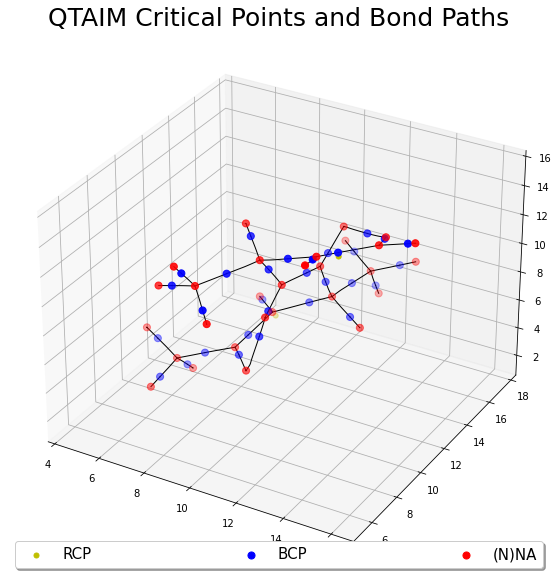

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
    
# Plot the critical points and bond paths
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
# Plot the bond paths
for i in range(0, len(topo.bcp)):
    for j in range(0, 2):
        p = topo.bp[i][j]
        ax.plot(p[:, 0], p[:, 1], p[:, 2], c="k", linewidth=1)
# Plot the critical points
if len(rcp) != 0:
    ax.scatter(rcp[:, 0], rcp[:, 1], rcp[:, 2], c="y", label="RCP", s=25)
if len(ccp) != 0:
    ax.scatter(ccp[:, 0], ccp[:, 1], ccp[:, 2], c="m", label="CCP", s=25)
ax.scatter(bcp[:, 0], bcp[:, 1], bcp[:, 2], c="b", label="BCP", s=50)
ax.scatter(nna[:, 0], nna[:, 1], nna[:, 2], c="r", label="(N)NA", s=50)
plt.legend(loc="lower center", shadow=True, fontsize=15, ncol=4, mode="expand") #
plt.title("QTAIM Critical Points and Bond Paths", fontsize=25)
plt.show()

## Challenging Cases

This example will illustrate a case, with a much large peptide, where the default initial guesses were not sufficient for finding all of the critical points. This can be determined from the Poincare-Hopf equation not being satisfied.  In such scenario, the user will need to add more and better initial guesses. 
 
This example will use [Grid](https://grid.qcdevs.org/pyapi/grid.atomgrid.html) package to construct an Becke-Lebedev grid (Atomic Grid) around each atom.  This is based on constructing grids over spherical coordinates $(r, \theta, \phi)$, where a radial grid is constructed over the $r$ coordinate and an angular grid over the $(\theta, \phi)$ coordinate. Due to the large size of the format check-point file, the user will need to use git lfs to download the file via the command `git lfs fetch --all`. 

In [5]:
import cugbasis
import numpy as np

# Load the wavefunction information
fchk_path = "./PHE_TRP_peptide_uwb97xd_def2svpd.fchk"
mol = cugbasis.Molecule(fchk_path)

# Get the atomic coordinates and numbers
atom_coords = mol.atcoords
atom_numbers = mol.atnums
natoms = atom_coords.shape[0]

In [6]:
from grid.onedgrid import OneDGrid
from grid.atomgrid import AtomGrid

# Construct a radial grid will upper bound (1.5) and step-size (0.25) 
#   to propogate out of each atom
u_bnd_rad = 1.5
ss_rad = 0.25
rad_grid = np.arange(0.0, u_bnd_rad, ss_rad)
rgrid = OneDGrid(points=rad_grid, weights=np.empty(rad_grid.shape))

# Construct a Becke-Lebedev grid around each atom using the 
#    previous radial grid
atom_grids_list = []
for i in range(natoms):
    atomic_grid = AtomGrid.from_preset(
        10, preset="fine", rgrid=rgrid, center=atom_coords[i]
    )
    atom_grids_list.append(atomic_grid.points)
    
# Concatenate all of the points together to make the initial guess
pts = np.vstack(atom_grids_list)

In [7]:
from chemtools.topology.critical import Topology

dens_func = mol.compute_density
grad_func = mol.compute_gradient
hess_func = mol.compute_hessian

topo = Topology(dens_func, grad_func, hess_func, coords=atom_coords, points=pts)
topo.find_critical_points_vectorized(atom_coords, use_log=True, verbose=False)

print(f"Is Poincare-Hopf Equation Satisfied?:  {topo.poincare_hopf_equation}")
topo.find_bond_paths(tol=1e-8, max_ss=0.1)

Is Poincare-Hopf Equation Satisfied?:  True


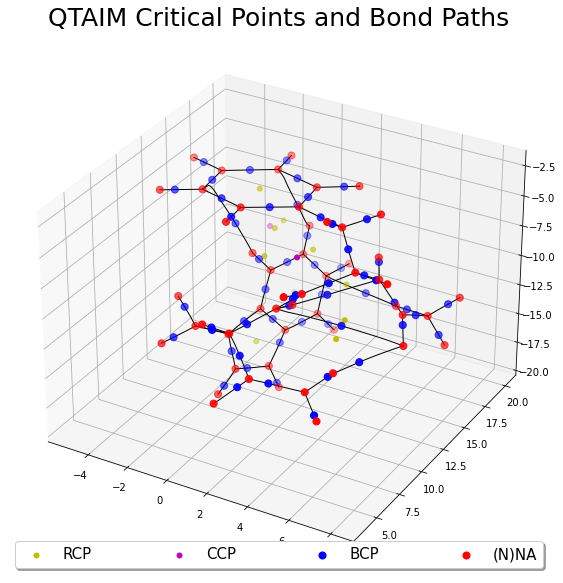

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Grab the critical points
bcp = np.array([x.coordinate for x in topo.bcp])
nna = np.array([x.coordinate for x in topo.nna])
rcp = np.array([x.coordinate for x in topo.rcp])
ccp = np.array([x.coordinate for x in topo.ccp])
    
# Plot the critical points and bond paths
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
# Plot the bond paths
for i in range(0, len(topo.bcp)):
    for j in range(0, 2):
        p = topo.bp[i][j]
        ax.plot(p[:, 0], p[:, 1], p[:, 2], c="k", linewidth=1)
# Plot the critical points
if len(rcp) != 0:
    ax.scatter(rcp[:, 0], rcp[:, 1], rcp[:, 2], c="y", label="RCP", s=25)
if len(ccp) != 0:
    ax.scatter(ccp[:, 0], ccp[:, 1], ccp[:, 2], c="m", label="CCP", s=25)
ax.scatter(bcp[:, 0], bcp[:, 1], bcp[:, 2], c="b", label="BCP", s=50)
ax.scatter(nna[:, 0], nna[:, 1], nna[:, 2], c="r", label="(N)NA", s=50)
plt.legend(loc="lower center", shadow=True, fontsize=15, ncol=4, mode="expand") #
plt.title("QTAIM Critical Points and Bond Paths", fontsize=25)
plt.show()